In [125]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.features import shapes
from shapely.geometry import shape
from shapely.ops import unary_union
import os
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import contextily as ctx

# Ensure to run this in a Jupyter Notebook environment
%matplotlib inline

## Land cover exploration for AOIs

### Source 1:  Copernicus Land Monitoring Service, 100m resolution fine-grained land use maps [https://lcviewer.vito.be/about#available-maps ](https://lcviewer.vito.be/2019)

### Source 2: 10-meter resolution GeoTIFF files for each year of the Sentinel-2 Land Use/Land Cover map produced by Esri, Microsoft, and Impact Observatory. The map is derived from ESA Sentinel-2 imagery and is a composite of land use/land cover predictions for 9 classes for each year from 2017-2021. https://livingatlas.arcgis.com/landcoverexplorer/ 

In [117]:
data_lut = [
    {"Value": 0, "Color": "#282828", "Description": "Unknown. No or not enough satellite data available."},
    {"Value": 20, "Color": "#ffbb22", "Description": "Shrubs. Woody perennial plants with persistent and woody stems and without any defined main stem being less than 5 m tall. The shrub foliage can be either evergreen or deciduous."},
    {"Value": 30, "Color": "#ffff4c", "Description": "Herbaceous vegetation. Plants without persistent stem or shoots above ground and lacking definite firm structure. Tree and shrub cover is less than 10 %."},
    {"Value": 40, "Color": "#f096ff", "Description": "Cultivated and managed vegetation / agriculture. Lands covered with temporary crops followed by harvest and a bare soil period (e.g., single and multiple cropping systems). Note that perennial woody crops will be classified as the appropriate forest or shrub land cover type."},
    {"Value": 50, "Color": "#fa0000", "Description": "Urban / built up. Land covered by buildings and other man-made structures."},
    {"Value": 60, "Color": "#b4b4b4", "Description": "Bare / sparse vegetation. Lands with exposed soil, sand, or rocks and never has more than 10 % vegetated cover during any time of the year."},
    {"Value": 70, "Color": "#f0f0f0", "Description": "Snow and ice. Lands under snow or ice cover throughout the year."},
    {"Value": 80, "Color": "#0032c8", "Description": "Permanent water bodies. Lakes, reservoirs, and rivers. Can be either fresh or salt-water bodies."},
    {"Value": 90, "Color": "#0096a0", "Description": "Herbaceous wetland. Lands with a permanent mixture of water and herbaceous or woody vegetation. The vegetation can be present in either salt, brackish, or fresh water."},
    {"Value": 100, "Color": "#fae6a0", "Description": "Moss and lichen."},
    {"Value": 111, "Color": "#58481f", "Description": "Closed forest, evergreen needle leaf. Tree canopy >70 %, almost all needle leaf trees remain green all year. Canopy is never without green foliage."},
    {"Value": 112, "Color": "#009900", "Description": "Closed forest, evergreen broad leaf. Tree canopy >70 %, almost all broadleaf trees remain green year round. Canopy is never without green foliage."},
    {"Value": 113, "Color": "#70663e", "Description": "Closed forest, deciduous needle leaf. Tree canopy >70 %, consists of seasonal needle leaf tree communities with an annual cycle of leaf-on and leaf-off periods."},
    {"Value": 114, "Color": "#00cc00", "Description": "Closed forest, deciduous broad leaf. Tree canopy >70 %, consists of seasonal broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods."},
    {"Value": 115, "Color": "#4e751f", "Description": "Closed forest, mixed."},
    {"Value": 116, "Color": "#007800", "Description": "Closed forest, not matching any of the other definitions."},
    {"Value": 121, "Color": "#666000", "Description": "Open forest, evergreen needle leaf. Top layer- trees 15-70 % and second layer- mixed of shrubs and grassland, almost all needle leaf trees remain green all year. Canopy is never without green foliage."},
    {"Value": 122, "Color": "#8db400", "Description": "Open forest, evergreen broad leaf. Top layer- trees 15-70 % and second layer- mixed of shrubs and grassland, almost all broadleaf trees remain green year round. Canopy is never without green foliage."},
    {"Value": 123, "Color": "#8d7400", "Description": "Open forest, deciduous needle leaf. Top layer- trees 15-70 % and second layer- mixed of shrubs and grassland, consists of seasonal needle leaf tree communities with an annual cycle of leaf-on and leaf-off periods."},
    {"Value": 124, "Color": "#a0dc00", "Description": "Open forest, deciduous broad leaf. Top layer- trees 15-70 % and second layer- mixed of shrubs and grassland, consists of seasonal broadleaf tree communities with an annual cycle of leaf-on and leaf-off periods."},
    {"Value": 125, "Color": "#929900", "Description": "Open forest, mixed."},
    {"Value": 126, "Color": "#648c00", "Description": "Open forest, not matching any of the other definitions."},
    {"Value": 200, "Color": "#000080", "Description": "Oceans, seas. Can be either fresh or salt-water bodies."}
]

df_lut_100m = pd.DataFrame(data_lut)
print(df_lut_100m.head())

   Value    Color                                        Description
0      0  #282828  Unknown. No or not enough satellite data avail...
1     20  #ffbb22  Shrubs. Woody perennial plants with persistent...
2     30  #ffff4c  Herbaceous vegetation. Plants without persiste...
3     40  #f096ff  Cultivated and managed vegetation / agricultur...
4     50  #fa0000  Urban / built up. Land covered by buildings an...


In [118]:
df_lut_100m.to_csv("../data/copernicus_LULC_100m_fine_classes.csv", index=False)

In [120]:
# Define the lookup table with class descriptions and colors
data = {
    "Description": ["Water", "Trees", "Flooded vegetation", "Crops", "Built Area", "Bare ground", "Snow/Ice", "Clouds", "Rangeland"],
    "Value": [1, 2, 4, 5, 7, 8, 9, 10, 11],
    "Color": ["#1f77b4", "#2ca02c", "#17becf", "#ff7f0e", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22"]
}
df_lut_10m = pd.DataFrame(data)

In [121]:
df_lut_10m.to_csv(r"../data/impact_observatory_LULC_10m_coarse_classes.csv", index=False)

In [122]:
def process_raster_aoi(df_lut, raster_path, aoi_path, region_name, epsg_code_tif = 4326, pixel_resolution = 100):

    # Load the AOI polygon
    aoi = gpd.read_file(aoi_path)
    aoi = aoi.to_crs(f"EPSG:{epsg_code_tif}")

    # Load the raster file
    with rasterio.open(raster_path) as src:
        # Clip the raster with the AOI
        out_image, out_transform = mask(src, aoi.geometry, crop=True)
        out_meta = src.meta

    # Update the metadata for the clipped raster
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    # Calculate the class distribution inside the AOI
    # Convert the masked array to 1D and filter out the nodata values
    masked_data = out_image[0].flatten()
    masked_data = masked_data[masked_data != src.nodata]

    # Count the occurrences of each class
    class_distribution = Counter(masked_data)

    # Map the class distribution to descriptions
    class_distribution_df = pd.DataFrame(list(class_distribution.items()), columns=['Value', 'Count'])
    result_df = class_distribution_df.merge(df_lut, on='Value', how='left')

    # Calculate the area in square meters (assuming 10x10m pixel size)
    result_df['Area (sq km)'] = result_df['Count'] * pixel_resolution * pixel_resolution / 1_000_000

    # Calculate the percentage cover of total AOI for each class
    total_area = result_df['Area (sq km)'].sum()
    result_df['Percentage Cover (%)'] = (result_df['Area (sq km)'] / total_area) * 100

    print(result_df[['Description', 'Area (sq km)', 'Percentage Cover (%)', 'Count']].sort_values(by='Count', ascending=False))

    # Define the colormap and norm
    cmap = ListedColormap(df_lut['Color'])
    boundaries = df_lut['Value'].tolist() + [df_lut['Value'].max() + 1]
    norm = BoundaryNorm(boundaries, cmap.N)
    cmap.set_under(color='#00000000')
    cmap.set_over(color='#00000000')

    # Create the legend
    legend_patches = [Patch(color=row['Color'], label=row['Description'][:30]) for _, row in df_lut.iterrows()]

    # Plot the clipped raster and AOI
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the AOI
    aoi.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

    # Add a basemap
    ctx.add_basemap(ax, crs=aoi.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    # Plot the raster using out_image
    show(out_image[0], transform=out_transform, ax=ax, cmap=cmap, norm=norm)

    # Add the legend
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.axis('off')
    plt.title(f"{region_name} Land use")

                                         Description  Area (sq km)  \
3  Open forest, not matching any of the other def...        111.11   
0  Open forest, deciduous broad leaf. Top layer- ...         82.94   
4  Cultivated and managed vegetation / agricultur...         78.57   
1  Closed forest, deciduous broad leaf. Tree cano...         44.05   
2  Shrubs. Woody perennial plants with persistent...         21.70   
6  Herbaceous vegetation. Plants without persiste...         10.01   
7  Urban / built up. Land covered by buildings an...          1.30   
5  Closed forest, not matching any of the other d...          0.44   
8  Herbaceous wetland. Lands with a permanent mix...          0.08   
9  Permanent water bodies. Lakes, reservoirs, and...          0.01   

   Percentage Cover (%)  Count  
3             31.726678  11111  
0             23.682933   8294  
4             22.435110   7857  
1             12.578167   4405  
2              6.196282   2170  
6              2.858285   1001 

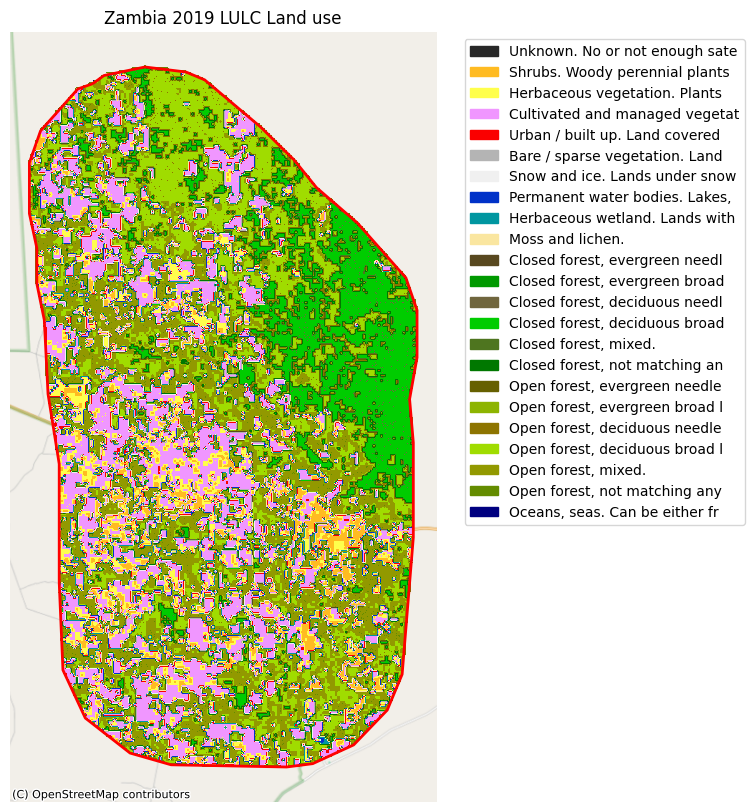

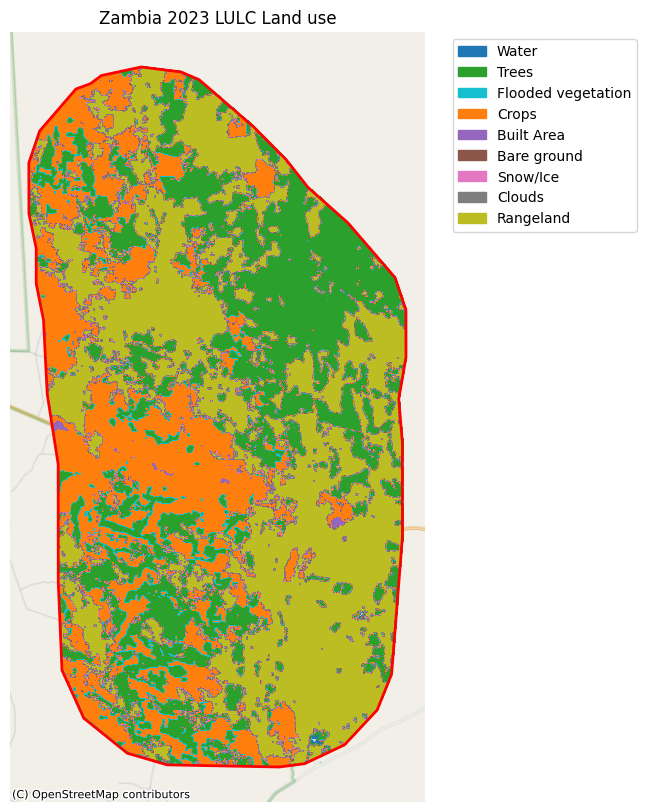

In [123]:
# ZAMBIA
aoi_path = r"C:\SD\correlaid_sensingclues\aoi\AoI_Zambia_By_Life_Connected.geojson"

# 100m 2019
raster_path = r"C:\SD\correlaid_sensingclues\aoi\ZAMBIA_E020N00_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif"
process_raster_aoi(df_lut_100m, raster_path, aoi_path, "Zambia 2019 LULC", 4326, 100)

# 10m 2023
raster_path = r"C:\SD\correlaid_sensingclues\aoi\ZAMBIA_2023_35L_20230101-20240101.tif"
process_raster_aoi(df_lut_10m, raster_path, aoi_path, "Zambia 2023 LULC", 32735, 10)

                                          Description  Area (sq km)  \
1   Open forest, not matching any of the other def...       1035.82   
5   Closed forest, deciduous broad leaf. Tree cano...       1022.34   
3   Closed forest, not matching any of the other d...        695.94   
0   Herbaceous vegetation. Plants without persiste...        566.48   
4   Closed forest, evergreen needle leaf. Tree can...        280.85   
2   Shrubs. Woody perennial plants with persistent...        147.40   
6   Cultivated and managed vegetation / agricultur...        130.71   
7   Open forest, deciduous broad leaf. Top layer- ...         92.03   
9   Urban / built up. Land covered by buildings an...         23.63   
10  Permanent water bodies. Lakes, reservoirs, and...          3.30   
12                              Closed forest, mixed.          3.29   
11  Herbaceous wetland. Lands with a permanent mix...          2.40   
8   Open forest, evergreen needle leaf. Top layer-...          1.77   

    P

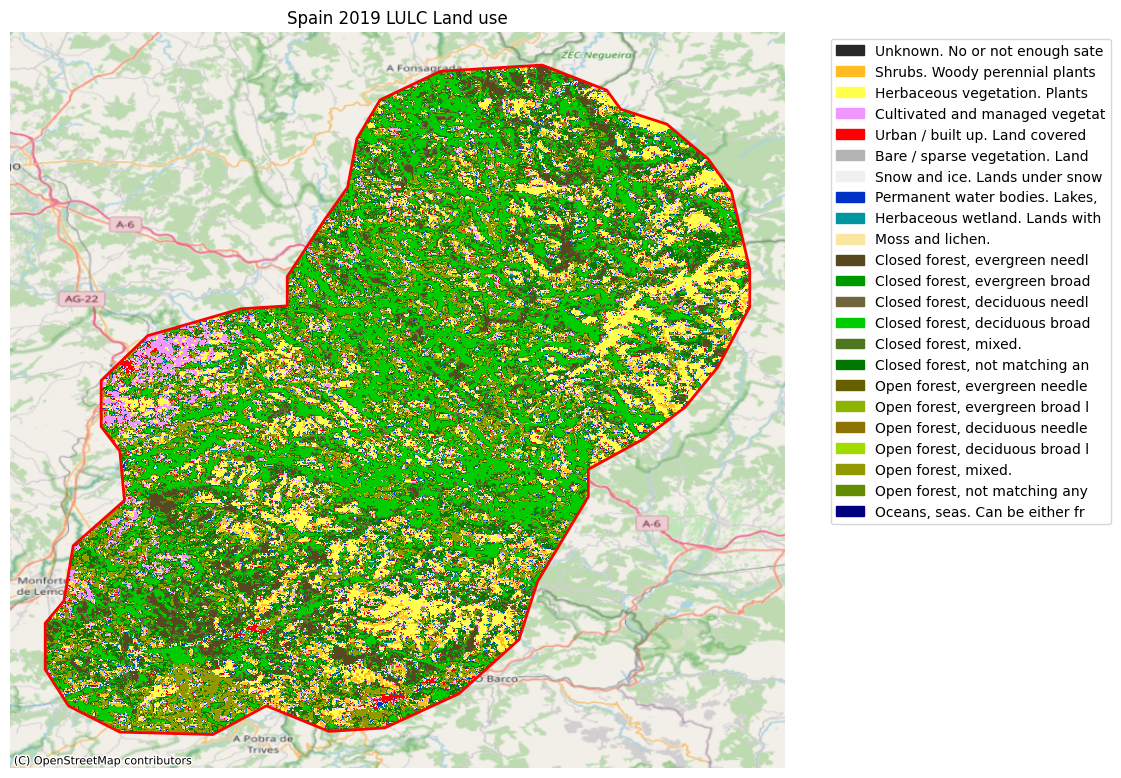

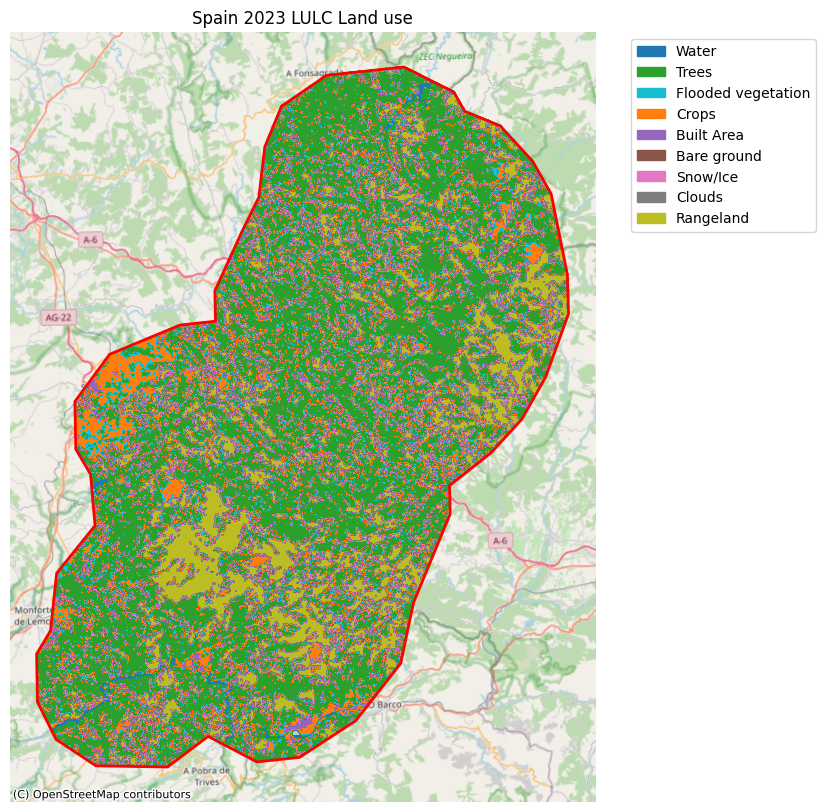

In [124]:
# ZAMBIA
aoi_path = r"C:\SD\correlaid_sensingclues\aoi\AoI_Spain_3eData.geojson"

# 100m 2019
raster_path = r"C:\SD\correlaid_sensingclues\aoi\SPAIN_60_PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326.tif"
process_raster_aoi(df_lut_100m, raster_path, aoi_path, "Spain 2019 LULC", 4326, 100)

# 10m 2023
raster_path = r"C:\SD\correlaid_sensingclues\aoi\SPAIN_2023_LULC.tif"
process_raster_aoi(df_lut_10m, raster_path, aoi_path, "Spain 2023 LULC", 32629, 10)

In [ ]:
def process_raster_aoi(df_lut_path, raster_path, aoi_path, region_name, output_dir, epsg_code_tif=32735):
    """
    Processes a raster file by clipping it to an Area of Interest (AOI) and extracting polygons based on a lookup table.

    Parameters:
    - df_lut_path (str): Path to the CSV file containing the lookup table (LUT) with 'Description' and 'Value' columns.
    - raster_path (str): Path to the input raster file.
    - aoi_path (str): Path to the shapefile of the Area of Interest (AOI).
    - region_name (str): Name of the region for naming output files.
    - output_dir (str): Directory to save the output GeoJSON files.
    - epsg_code_tif (int, optional): EPSG code for the target coordinate reference system. Default is 32735.

    Returns:
    None
    """
    
    df_lut = pd.read_csv(df_lut_path)

    # Load the AOI polygon
    aoi = gpd.read_file(aoi_path)
    aoi = aoi.to_crs(f"EPSG:{epsg_code_tif}")

    # Load the raster file
    with rasterio.open(raster_path) as src:
        # Clip the raster with the AOI
        out_image, out_transform = mask(src, aoi.geometry, crop=True)
        out_meta = src.meta

    # Update the metadata for the clipped raster
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    for index, row in df_lut.iterrows():
        desc = row['Description']
        value = row['Value']

        # Make polygons from pixel values equal to the LUT value
        mask_array = out_image[0] == value
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(
                shapes(out_image[0], mask=mask_array, transform=out_transform)
            )
        )

        geoms = list(results)
        polygons = gpd.GeoDataFrame.from_features(geoms)

        if len(polygons) == 0:
            continue

        # Merge polygons into as few polygons as possible
        merged_polygons = unary_union(polygons.geometry)

        # Save merged polygons to a file
        merged_gdf = gpd.GeoDataFrame(geometry=[merged_polygons], crs=f"EPSG:{epsg_code_tif}")
        output_file = os.path.join(output_dir, f"{region_name}_{desc.replace(' ', '_')}.geojson")
        merged_gdf.to_file(output_file, driver='GeoJSON')

    return

In [ ]:
# Zambia
polygons = process_raster_aoi(df_lut_path= r"../data/impact_observatory_LULC_10m_coarse_classes.csv", raster_path=r"C:\SD\correlaid_sensingclues\aoi\ZAMBIA_2023_35L_20230101-20240101.tif", aoi_path = r"C:\SD\correlaid_sensingclues\aoi\AoI_Zambia_By_Life_Connected.geojson", region_name = "Zambia", output_dir=r"../data/10m_lulc")

In [ ]:
spain_raster = r"C:\SD\correlaid_sensingclues\environmental-time-series\data\10m_lulc\SPAIN_2023_LULC.tif"
spain_aoi = r"C:\SD\correlaid_sensingclues\environmental-time-series\data\aoi\AoI_Spain_3eData.geojson"

polygons = process_raster_aoi(df_lut_path= r"../data/impact_observatory_LULC_10m_coarse_classes.csv", raster_path=spain_raster, aoi_path = spain_aoi, region_name = "Spain", output_dir=r"../data/10m_lulc", epsg_code_tif=32629)
